Determining Heat Removal Requirements for Data

Test 1: 40 kW: c:\VSCode_Python\LapSim_V2\sim_inputs_and_outputs\dynamicsCalcs_40kW.csv

In [1]:
# Resets and clears all variables from kernel
%reset

Nothing done.


In [2]:
import pandas as pd
import numpy as np

infile = "../sim_inputs_and_outputs/dynamicsCalcs.csv"
version = ""

data = pd.read_csv(infile)

# CONSTANTS
num_parallel_cells = 5
thermal_resistance_in = 2.21714     # K/W
thermal_resistance_out = 10.6106    # K/W
single_cell_ir = 0.028              # Ohms
air_temp = 30                       # C
battery_heat_capacity = 35.098      # J/K (Calculated from Simulation)

In [3]:
import matplotlib.pyplot as plt
### driverSwapCooling
## Calculate the decrease in temperature of the cells during the driver swap
## Assume that LV batteries on car allow fans to continue running while car is stoppedd
def driverSwapCooling(dataDict, i, TR0):

    # set up constants
    air_temp_K = air_temp + 273.15      # Convert to K from C
    totalTimeMins = 5                   # Driver swap time in mins
    totalTimeSecs = totalTimeMins * 60  # time in secs
    numElems = totalTimeSecs * 5        # 5 measurements per second
    timeVector = np.linspace(0, totalTimeSecs, numElems)    # time measurements
    batteryTemp = np.zeros(numElems)                        # battery temperature vector
    cellQout = np.zeros(numElems)                           # heat out vector
    cellQgen = 0                                            # 0 generated heat
    dt = totalTimeSecs / numElems                           # time interval

    batteryTemp[0] = dataDict["Battery Temp"][i]            # Set battery temperature to the final value
    cellQout[0] = dataDict["Cell Qout"][i]                  # Same with heat out

    # Iterate over 5 minutes of time to determine how much the cell temperature decreases with no power generated    
    for j in range(0, len(timeVector)-1):

        battery_temp_K = (((cellQgen * TR0 + air_temp_K) * dt
                        + (batteryTemp[j] + 273.15) * battery_heat_capacity * (thermal_resistance_in + TR0))
                        / (battery_heat_capacity * (thermal_resistance_in + TR0) + dt))
        
        batteryTemp[j+1] = battery_temp_K - 273.15     # Convert back to C from K

        # Calculate net heat generation rate (Qgen - Qtransferred)
        cellQout[j] = 1 / TR0 * (batteryTemp[j] - air_temp)

    # Update the last value prior to stopping with the new lower temperature (AFTER driver swap)
    # Otherwise, will be too hard to add this data into the system (seeing as it updates based on distance travelled)
    dataDict['Battery Temp'][i+1] = batteryTemp[-1]

    # For debugging purposes, plot some stuff
    plt.plot(timeVector, batteryTemp)
    plt.xlabel("Time (seconds)")
    plt.ylabel("Temperature (C)")
    plt.title("Battery Temperature over Time")
    plt.grid(True)
    plt.savefig("thermalPlots/batteryCoolingDuringDriverSwap_test.png")

    return dataDict

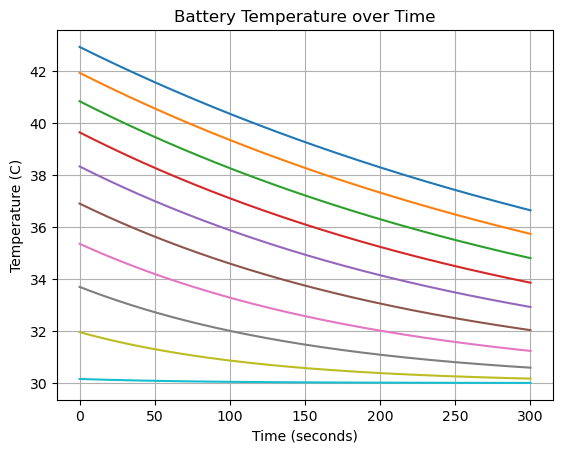

In [4]:
# Create list of dataDicts so that I can compare outputs amongst options
testData = []
maxTemps = []
totalEnergyOut = []
thermal_R_out_list = np.linspace(10.6106, 0.1, 10)  # Based on the literature (Bryden et al.), the result should be no less than this
# thermal_R_out_list = np.insert(thermal_R_out_list, 0, 100000)    # Adding an adiabatic condition to the test set

# For requried input data (that does not change!)
dataDict = data[['r0', 't0', 'Cell Qgen', 'Cell Total Gen']].copy()
dataDict = dataDict.to_dict('list')
length = len(dataDict["t0"])

# Collect output data
outData = []

for thermal_R_out in thermal_R_out_list:

    # For new data:
    # Initialize dict for Battery Temp, Cell Qout, Cell Net Q, Cell Total Qout, Cell Net Heat
    tempDict = dict({'Battery Temp': np.zeros(length),
                     'Cell Qout': np.zeros(length),
                     'Cell Net Q': np.zeros(length),
                     'Cell Total Qout': np.zeros(length),
                     'Cell Net Heat': np.zeros(length)})
    
    # Only need to set 1 initial value:
    tempDict["Battery Temp"][0] = air_temp
    driverSwap = False
    
    # Begin iteration:
    for i in range(0,length - 1):
        dt = dataDict['t0'][i+1] - dataDict['t0'][i]        # dt in units of seconds :)

        # NOTE TO SELF:
        # Look at my notes on confluence (https://ubcformulaelectric.atlassian.net/wiki/spaces/UFE/pages/edit-v2/405438472)
        # for how I came across this formula (and to verify that it is correct)
        air_temp_K = air_temp + 273.15      # Convert to K from C

        battery_temp_K = (((dataDict['Cell Qgen'][i] * thermal_R_out + air_temp_K) * dt
                        + (tempDict['Battery Temp'][i] + 273.15) * battery_heat_capacity * (thermal_resistance_in + thermal_R_out))
                        / (battery_heat_capacity * (thermal_resistance_in + thermal_R_out) + dt))

        tempDict['Battery Temp'][i+1] = battery_temp_K - 273.15     # Convert back to C from K

        # Calculate net heat generation rate (Qgen - Qtransferred)
        tempDict['Cell Qout'][i] = 1 / thermal_R_out * (tempDict['Battery Temp'][i] - air_temp)
        tempDict['Cell Net Q'][i] = dataDict['Cell Qgen'][i] - tempDict['Cell Qout'][i]

        # Add up heat removed from cells (J)
        if i != 0:
            # Now determine the energy parameters:
            dt = dataDict['t0'][i] - dataDict['t0'][i-1]

            thisOut = 1/2*(tempDict["Cell Qout"][i] + tempDict["Cell Qout"][i-1]) * dt
            tempDict["Cell Total Qout"][i+1] = tempDict["Cell Total Qout"][i] + thisOut

            # Add up net heat generated from cells (J)
            thisNet = 1/2*(tempDict["Cell Net Q"][i] + tempDict["Cell Net Q"][i-1]) * dt
            tempDict['Cell Net Heat'][i+1] = tempDict['Cell Net Heat'][i] + thisNet

        if driverSwap == False and data['r0'][i] > 11000:
            ## Cool the cells
            driverSwap = True
            tempDict = driverSwapCooling(tempDict, i, thermal_R_out)

    # Set special variables and saving of data
    maxCellTemperature = max(tempDict['Battery Temp'])
    outData.append(tempDict)

    lastElem = length - 1
    totalOutputEnergy = tempDict["Cell Total Qout"][lastElem]

    maxTemps.append(maxCellTemperature)
    totalEnergyOut.append(totalOutputEnergy)
    testData.append(tempDict)

In [5]:
# Save the tempDict data to a pkl file to look at
import pickle
with open("Heat_Removal.pkl", 'wb') as file:
    pickle.dump(outData[0], file)

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import scipy
import math

DCIR = 0.02         # Ohms - DC internal resistance
capacity = 2.8      # Ah

# load pickle file
with open("Heat_Removal.pkl", 'rb') as file:
    outData = pickle.load(file)

# Compare against the normal sim results:
batteryTemp = outData['Battery Temp']
CellQout = outData['Cell Qout']
CellNetQ = outData['Cell Net Q']
CellTotalQout = outData['Cell Total Qout']
CellNetHeat = outData['Cell Net Heat']

# Upload the normal sim results
simDict = pd.read_csv("../sim_inputs_and_outputs/dynamicsCalcs.csv")

# Determine what the TIME average heat generated is from the cells
x = simDict['t0']
y = simDict['Cell Qgen']
maxTime = x[len(x) - 1]
avg_Qgen = scipy.integrate.trapezoid(y, x) / maxTime
avg_Qgen

# Equivalence in charge current:
current = math.sqrt(avg_Qgen / DCIR)
CRate = current / capacity

print("Current: %.3f A" % current)
print("C Rate: %.3f" % CRate)
print("Average Generated Heat Per Cell: %.3f W" % avg_Qgen)
print("Final SoC: %.3f %%" % data['SoC Capacity'][len(data) - 1])

###### Now calculate based on C Rate
delta_SoC = data['SoC Capacity'][0] - data['SoC Capacity'][len(data) - 1]
totalTime = data['t0'][len(data) - 1]
SoC_to_Current = delta_SoC / 100 * capacity / (totalTime / 3600)
SoC_to_Qgen = SoC_to_Current**2 * DCIR

print("\n")
print("Current from SoC: %.3f A" % SoC_to_Current)
print("Generated Heat from SoC: %.3f W" % SoC_to_Qgen)

delta_SoC

Current: 8.990 A
C Rate: 3.211
Average Generated Heat Per Cell: 1.616 W
Final SoC: 15.735 %


Current from SoC: -0.960 A
Generated Heat from SoC: 0.018 W


-14.735462067614051

In [1]:
# # Plot the results against each other
# plt.plot(simDict['t0'], batteryTemp, label='thisTemp')
# plt.plot(simDict['t0'], simDict['Battery Temp'], label='SimTemp')
# plt.legend()
# plt.title("Temperature Comparison")
# plt.grid(True)
# plt.show()

# plt.plot(simDict['t0'], CellQout, label='thisQout')
# plt.plot(simDict['t0'], simDict['Cell Qout'], label='simQout')
# plt.legend()
# plt.title("Qout Comparison")
# plt.grid(True)
# plt.show()

# plt.plot(simDict['t0'], CellTotalQout, label='thisTotalQout')
# plt.plot(simDict['t0'], simDict['Cell Total Qout'], label='simTotalQout')
# plt.legend()
# plt.title("Total Qout Comparison")
# plt.grid(True)
# plt.show()

# plt.plot(simDict['t0'], CellNetHeat, label='thisNetHeat')
# plt.plot(simDict['t0'], simDict['Cell Net Heat'], label='simNetHeat')
# plt.legend()
# plt.title("Net Heat Comparison")
# plt.grid(True)
# plt.show()

# plt.plot(dataDict['t0'], dataDict['Cell Qgen'], label='thisQgen')
# plt.plot(simDict['t0'], simDict['Cell Qgen'], label='simQgen')
# plt.legend()
# plt.title("Qgen Comparison")
# plt.grid(True)
# plt.show()

Determine maximum and average generated heat

In [8]:
index = np.searchsorted(dataDict['t0'], 1200)
cell_Qgen = dataDict['Cell Qgen'][0:index]

cell_Qgen

maxGen = np.max(cell_Qgen)
avgGen = np.mean(cell_Qgen)

print("Maximum Generated Heat: %.3f W" % maxGen)
print("Average Generated Heat: %.3f W" % avgGen)

Maximum Generated Heat: 3.254 W
Average Generated Heat: 1.646 W


Now let's plot the outputs on top of each other

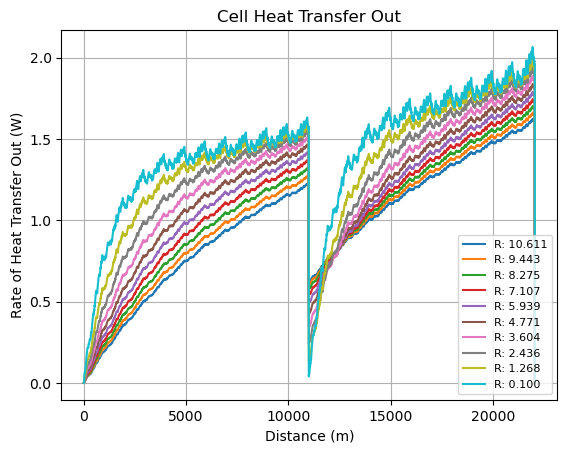

In [9]:
import matplotlib.pyplot as plt

for outputData, thermal_R in zip(testData, thermal_R_out_list):
    
    if thermal_R < 100:
        name = ('R: %.3f' % thermal_R) 
        plt.plot(dataDict["r0"], outputData["Cell Qout"], label=name)

        # maxOut = max(outputData["Cell Qout"])
        # maxOutIndex = list(outputData["Cell Qout"]).index(maxOut)
        # maxOutTime = dataDict["r0"][maxOutIndex]
        # plt.scatter(maxOutTime, maxOut, s=20, marker='o', edgecolors='k')

plt.title("Cell Heat Transfer Out")
plt.xlabel("Distance (m)")
plt.ylabel("Rate of Heat Transfer Out (W)")
plt.legend(fontsize='8')

plt.grid(True)
plt.savefig("thermalPlots/Heat_Transfer_Out_vary_Therm_R" + version + ".png")
plt.show()

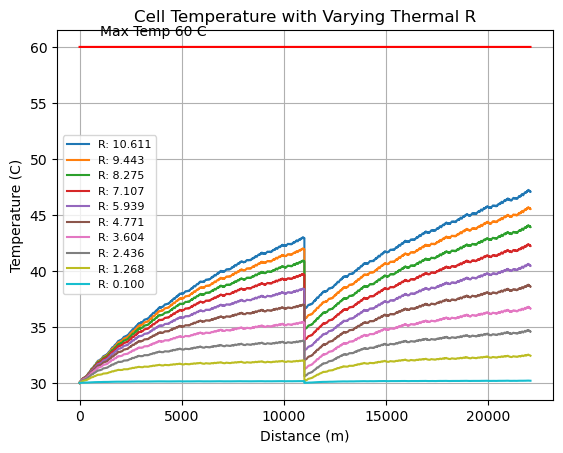

In [10]:
import matplotlib.pyplot as plt

for outputData, thermal_R, maxTemp in zip(testData, thermal_R_out_list, maxTemps):
    if thermal_R > 100:
        name = "Adiabatic Case"
    else:
        name = ('R: %.3f' % thermal_R)

        plt.plot(dataDict["r0"], outputData["Battery Temp"], label=name)

        # maxTempIndex = list(outputData["Battery Temp"]).index(maxTemp)
        # maxTempTime = dataDict["r0"][maxTempIndex]
        # plt.scatter(maxTempTime, maxTemp, s=20, marker='o', edgecolors='k')
    
# Add red line at 60 C
plt.plot(dataDict["r0"], np.ones(len(dataDict["r0"])) * 60, c='r')

plt.title("Cell Temperature with Varying Thermal R")
plt.xlabel("Distance (m)")
plt.ylabel("Temperature (C)")

textx = 1000
texty = 61
plt.text(textx, texty, "Max Temp 60 C")

plt.legend(fontsize='8')
plt.grid(True)
plt.savefig("thermalPlots/Cell_Temp_Vary_Therm_R" + version + ".png")
plt.show()

In [11]:
# import matplotlib.pyplot as plt

# for outputData, thermal_R, maxTemp in zip(testData, thermal_R_out_list, maxTemps):
#     if thermal_R > 100:
#         name = "Adiabatic Case"
#     else:
#         name = ('R: %.3f' % thermal_R)

#     plt.plot(dataDict["r0"], outputData["Battery Temp"], label=name)

#     # maxTempIndex = list(outputData["Battery Temp"]).index(maxTemp)
#     # maxTempTime = dataDict["r0"][maxTempIndex]
#     # plt.scatter(maxTempTime, maxTemp, s=20, marker='o', edgecolors='k')

# plt.title("Cell Temperature with Varying Thermal R")
# plt.xlabel("Distance (m)")
# plt.ylabel("Temperature (C)")

# plt.legend(fontsize='8')
# plt.grid(True)
# plt.savefig(("thermalPlots/Cell_Temp_Vary_Therm_R_adiabatic" + version + ".png"))
# plt.show()

So this tells us that we need an outward thermal resistance of less than 5.9 K/W. When I look at the averages of each of the options, there is not much difference, so the thermal resistance coefficient is likely more important for this modelling.

What does this correspond to for heat transfer coefficient?

In [12]:
from math import pi

max_thermal_resistance = 3.5  # K/W

# input as mm, output is m
circle_area = lambda r: (pi*r**2) / 1000**2
central_area = lambda r, h: (2*pi*r*h) / 1000**2
cylinder_area = lambda r, h: 2*circle_area(r) + central_area(r, h)

area_18650 = cylinder_area(18, 65)
area_26650 = cylinder_area(26, 65)

# Corresponding output based on paper results:
possible_Rs = thermal_R_out_list[thermal_R_out_list < max_thermal_resistance]

# Resulting values for 26650 to compare with paper
scaled_to_26 = np.array(possible_Rs) * area_18650 / area_26650

# Note that values below 1.6 K/W are likely not possible, considering the results of the study
print("Scaled to 26650: ", scaled_to_26)

# What this means to me is that we should be able to get reasonable heat removal from an air-cooled system

# Resulting heat transfer coefficient: R = 1/(hA) -therefore- h = 1/RA
htc = 1 / (area_18650 * np.array(possible_Rs))

# # If we only consider cooling from the bottom, then we'll see the following:
# bottom_area_18650 = (pi * 18**2) / 1000**2
# htc_axial = 1 / (bottom_area_18650 * np.array(possible_Rs))
# htc_axial


# The final area represents the module free central area not covered by 3D-printed plastic
areas = [cylinder_area(18, 65), circle_area(18), central_area(18, 65), 2*circle_area(18), central_area(18, 65) + circle_area(18), central_area(18, 41.8)]

for area in areas:
    htc = 1 / (area * np.array(possible_Rs))
    print("Area: %.3f" % area)
    print("Possible htcs: ", htc)

areas

Scaled to 26650:  [1.53800473 0.80057464 0.06314455]
Area: 0.009
Possible htcs:  [  43.73687195   84.02404058 1065.29413047]
Area: 0.001
Possible htcs:  [ 403.35115244  774.88837422 9824.3792032 ]
Area: 0.007
Possible htcs:  [  55.84862111  107.29223643 1360.29865891]
Area: 0.002
Possible htcs:  [ 201.67557622  387.44418711 4912.1896016 ]
Area: 0.008
Possible htcs:  [  49.05622124   94.24318065 1194.85693012]
Area: 0.005
Possible htcs:  [  86.84594191  166.84199445 2115.29695763]


[0.009387078848926301,
 0.0010178760197630929,
 0.0073513268094001155,
 0.0020357520395261858,
 0.008369202829163208,
 0.00472746862512192]